In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

In [2]:
# Define dataset path
BASE_DIR = '../dataset/emotion-recog-dataset'

# Emotion labels
emotion_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [3]:
# Prepare image paths and labels
image_paths = []
emotion_classes = []

for emotion in emotion_labels:
    emotion_dir = os.path.join(BASE_DIR, emotion)
    for filename in tqdm(os.listdir(emotion_dir)):
        image_path = os.path.join(emotion_dir, filename)
        image_paths.append(image_path)
        emotion_classes.append(emotion_labels.index(emotion))

100%|██████████| 1234/1234 [00:00<00:00, 308393.68it/s]


In [4]:
# Convert to DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'emotion': emotion_classes
})

In [5]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
# Display the first few rows of the DataFrame
print(df.columns)
print(df.head())

Index(['image', 'emotion'], dtype='object')
                                               image  emotion
0  ../dataset/emotion-recog-dataset\Neutral\0ac4b...        2
1  ../dataset/emotion-recog-dataset\Neutral\1aaf0...        2
2  ../dataset/emotion-recog-dataset\Sad\2da685103...        3
3  ../dataset/emotion-recog-dataset\Neutral\cropp...        2
4  ../dataset/emotion-recog-dataset\Sad\cropped_e...        3


In [7]:
# Map emotion labels to their names
emotion_dict = {i: emotion for i, emotion in enumerate(emotion_labels)}

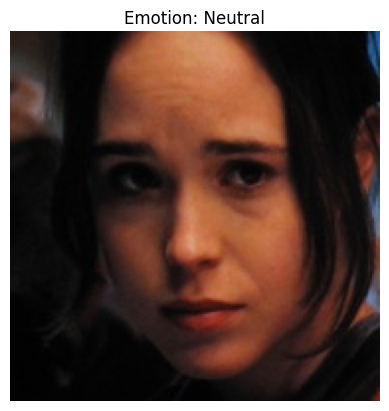

In [8]:
# Display the first image with its label
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)
plt.title(f"Emotion: {emotion_dict[df['emotion'][0]]}")
plt.show()

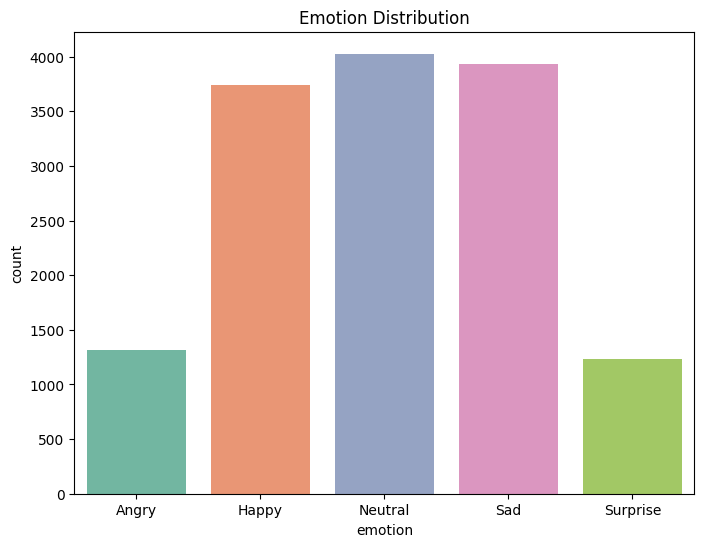

In [9]:
# Plot the distribution of emotions with proper labels
plt.figure(figsize=(8, 6))

# Use the emotion classes for the `hue` argument and disable the legend since it's redundant
sns.countplot(x='emotion', data=df, hue='emotion', palette='Set2', legend=False)

# Set x-tick labels to emotion names instead of numbers
plt.xticks(ticks=range(len(emotion_labels)), labels=emotion_labels)

plt.title("Emotion Distribution")
plt.show()

In [10]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

<Figure size 2000x2000 with 0 Axes>

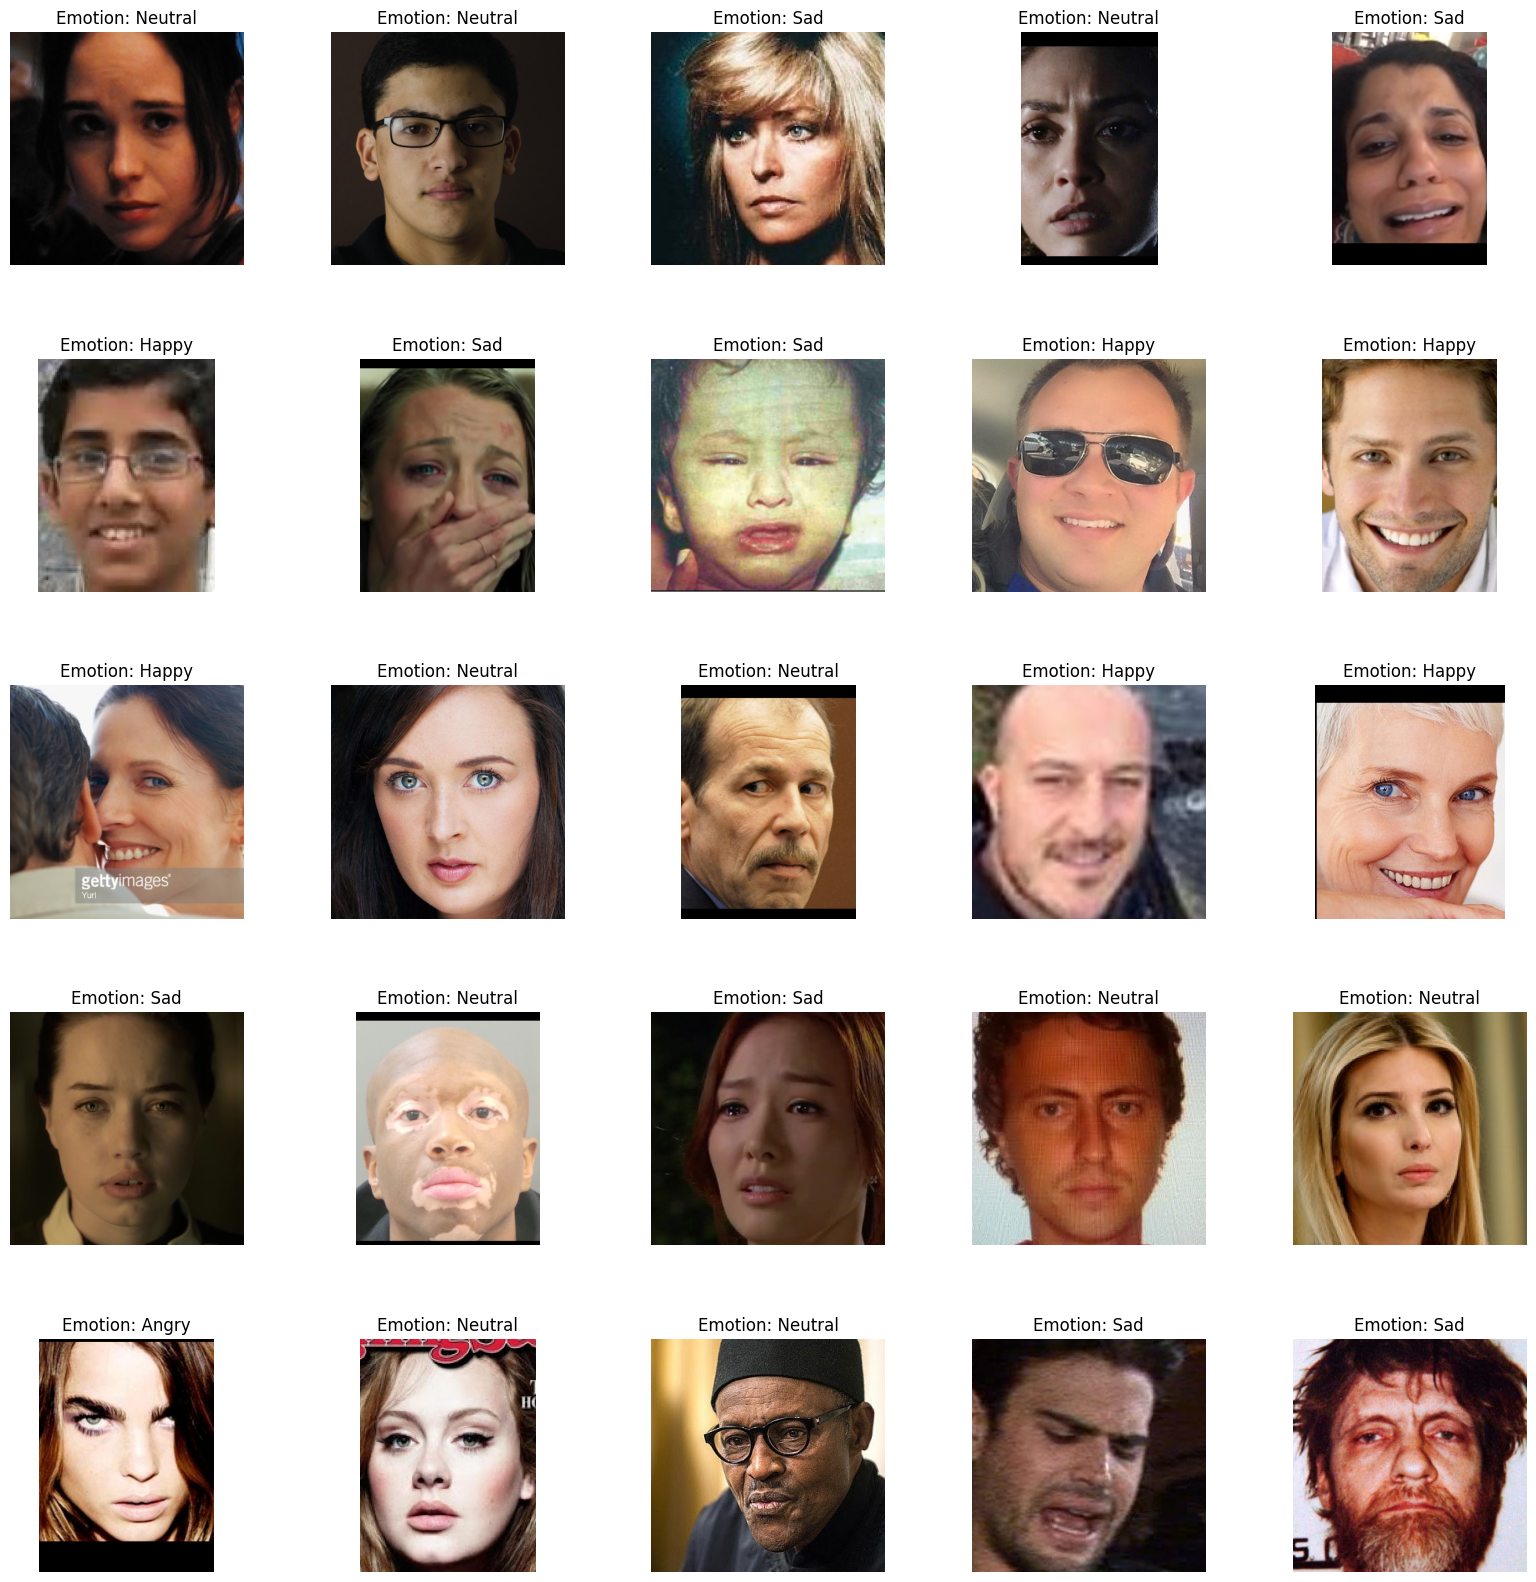

In [11]:
plt.figure(figsize=(20, 20))

# Adjust the spacing between images and titles
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # hspace controls height space, wspace controls width space

for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)
    
    file = row[0]
    emotion = row[1]
    
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Emotion: {emotion_dict[emotion]}")
    plt.axis('off')

plt.show()

In [12]:
# Function to extract features from images
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS) 
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])
X.shape

100%|██████████| 14248/14248 [02:11<00:00, 108.53it/s]


(14248, 128, 128, 1)

In [14]:
# Normalize the images
X = X / 255.0

In [15]:
# Convert labels to one-hot encoding
y_emotion = to_categorical(df['emotion'], num_classes=len(emotion_labels))

In [16]:
# Define the model input shape
input_shape = (128, 128, 1)
inputs = Input((input_shape))

In [ ]:
# # Define the convolutional layers
# conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
# maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
# dropout_conv_1 = Dropout(0.5)(maxp_1)  # Add dropout in conv layer

# conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
# maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
# dropout_conv_2 = Dropout(0.5)(maxp_2)  # Add dropout in conv layer

# conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
# maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
# dropout_conv_3 = Dropout(0.5)(maxp_3)  # Add dropout in conv layer

# conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
# maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
# dropout_conv_4 = Dropout(0.5)(maxp_4)  # Add dropout in conv layer

# flatten = Flatten()(dropout_conv_4)

# # Fully connected layers with L2 regularization
# dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)
# dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)

# dropout_1 = Dropout(0.6)(dense_1)
# dropout_2 = Dropout(0.6)(dense_2)

# # Output layer for emotion classification
# output_1 = Dense(len(emotion_labels), activation='softmax', name='emotion_out')(dropout_2)

# model = Model(inputs=[inputs], outputs=[output_1])

# # Compile the model
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=0.00005),
#     metrics=['accuracy']
# )

# # Define callbacks
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
#     ModelCheckpoint('../models/best_emotion_model.keras', monitor='val_loss', save_best_only=True)
# ]

In [ ]:
# Split your dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_emotion, test_size=0.2, random_state=42)

In [17]:
# Define data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define a simple generator for validation (no augmentation)
val_datagen = ImageDataGenerator()

# Create generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Define the convolutional layers with batch normalization
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
batchnorm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(batchnorm_1)
dropout_conv_1 = Dropout(0.3)(maxp_1)  # Reduced dropout to retain more information

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(batchnorm_2)
dropout_conv_2 = Dropout(0.3)(maxp_2)  # Reduced dropout

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)
dropout_conv_3 = Dropout(0.4)(maxp_3)  # Slightly higher dropout at deeper layers

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
batchnorm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)
dropout_conv_4 = Dropout(0.4)(maxp_4)

flatten = Flatten()(dropout_conv_4)

# Fully connected layers with reduced L2 regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)
batchnorm_dense_1 = BatchNormalization()(dense_1)
dropout_1 = Dropout(0.5)(batchnorm_dense_1)  # Higher dropout for dense layers

dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
batchnorm_dense_2 = BatchNormalization()(dense_2)
dropout_2 = Dropout(0.5)(batchnorm_dense_2)

# Output layer for emotion classification
output_1 = Dense(len(emotion_labels), activation='softmax', name='emotion_out')(dropout_2)

# Build the model
model = Model(inputs=[inputs], outputs=[output_1])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Slightly higher learning rate for faster learning
    metrics=['accuracy']
)

# Define callbacks with more aggressive learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('../models/best_emotion_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model with data augmentation using the separate train and validation generators
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100


c:\Users\twang\repo\ai2_del2_face_recognition\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 361ms/step - accuracy: 0.2242 - loss: 9.9814 - val_accuracy: 0.0909 - val_loss: 10.2713 - learning_rate: 1.0000e-04
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 136s 379ms/step - accuracy: 0.2622 - loss: 9.2637 - val_accuracy: 0.2863 - val_loss: 9.5000 - learning_rate: 1.0000e-04
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.2859 - loss: 8.6161 - val_accuracy: 0.2793 - val_loss: 9.7236 - learning_rate: 1.0000e-04
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 137s 384ms/step - accuracy: 0.3028 - loss: 8.0297 - val_accuracy: 0.2975 - val_loss: 9.4582 - learning_rate: 1.0000e-04
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 135s 378ms/step - accuracy: 0.3035 - loss: 7.4569 - val_accuracy: 0.2996 - val_loss: 8.9461 - learning_rate: 1.0000e-04
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 139s 387ms/step - accuracy: 0.3155 - loss: 6.8901 - val_accuracy: 0.3400 - val_loss: 7.3294 - learning_rate: 1.0000e-04
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s

In [ ]:
# # Train the model
# history = model.fit(
#     x=X,
#     y=y_emotion,
#     batch_size=32,
#     epochs=100,
#     validation_split=0.2,
#     callbacks=callbacks
# )

In [18]:
# Evaluate the model on the validation set used during training
val_loss, val_accuracy = model.evaluate(X[int(0.8*len(X)):], y_emotion[int(0.8*len(y_emotion)):])
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8361 - loss: 0.5156
Validation Accuracy: 83.58%


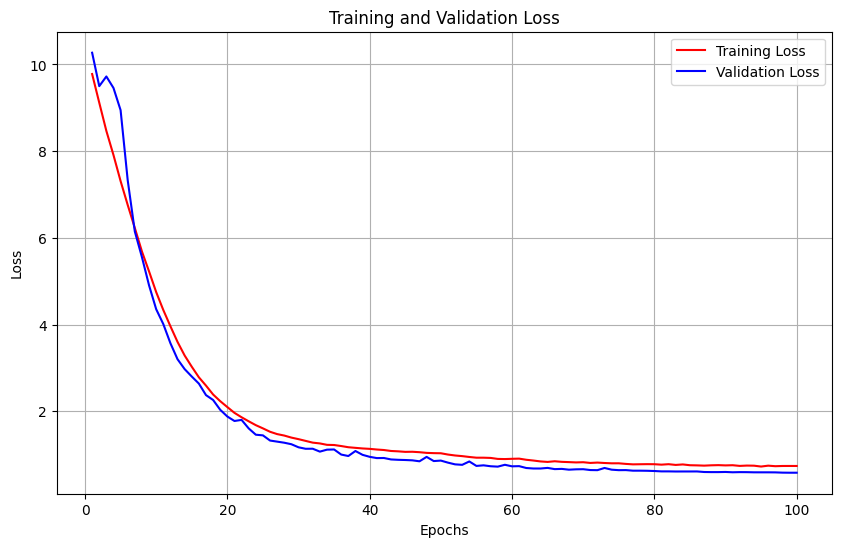

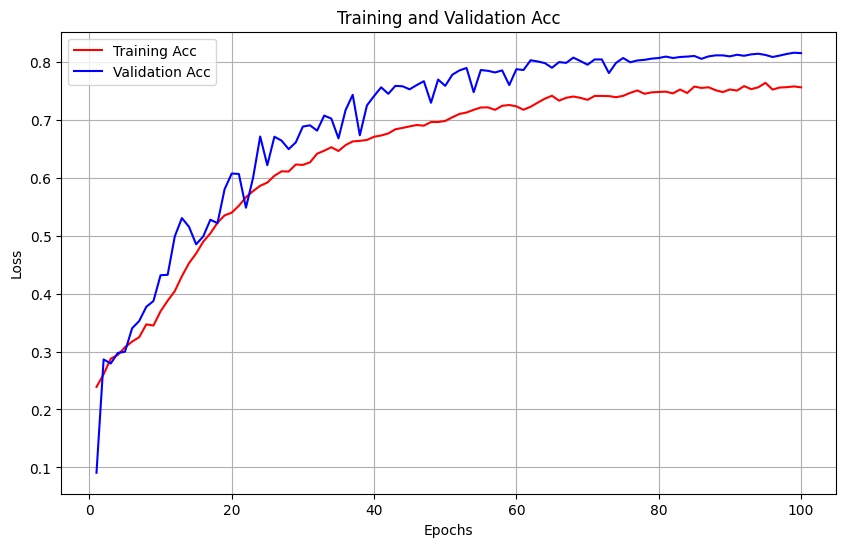

In [19]:
# Extract loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create epochs range
epochs = range(1, len(training_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract acc values
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

# Create epochs range
epochs = range(1, len(training_acc) + 1)

# Plotting the training and validation acc
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc, 'r', label='Training Acc')
plt.plot(epochs, validation_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Original Emotion:  Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion:  Sad


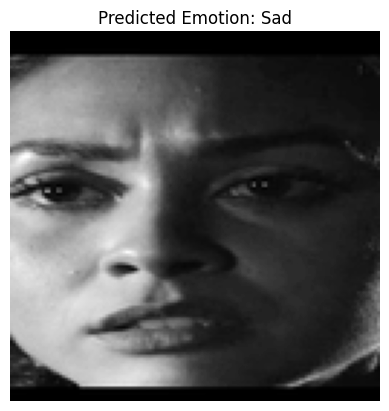

In [26]:
# Example of predicting emotion from a specific image
image_index = 3 # Just an example index
print("Original Emotion: ", emotion_dict[df['emotion'][image_index]])

# Predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_emotion = emotion_dict[np.argmax(pred)]

print("Predicted Emotion: ", pred_emotion)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.title(f"Predicted Emotion: {pred_emotion}")
plt.show()